# Explainable Models

In [15]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import shap
import pandas as pd

### Autoencoder Trained Classification Model

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_columns=66, output_size=18, hidden_size=33, dropout_p=0.1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ffn = nn.Sequential(
            nn.Linear(input_columns, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.ffn(x)
    
class En_Classifier(nn.Module):
    def __init__(self, input_columns=66, hidden_size_encoder=33, embedding_size = 18, hidden_size=6, output_size=3, dropout_p=0.1, encoder_checkpoint_path: str=None, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = Encoder(input_columns=input_columns, output_size=embedding_size, hidden_size=hidden_size_encoder, dropout_p=dropout_p)
        if encoder_checkpoint_path is not None:
            self.encoder.load_state_dict(torch.load(encoder_checkpoint_path))
        self.classifier = nn.Sequential(
            nn.Linear(embedding_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embeddings = self.encoder(x)
        return self.classifier(embeddings)

In [10]:
class Horse_Health_Dataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        if x.shape[0] != y.shape[0]:
            raise Exception("Dataset Error: Sizes of X and y dont match")
        
        x_tensor = torch.from_numpy(x)
        y_tensor = torch.from_numpy(y)
        self.X = x_tensor.to(device)
        self.y = y_tensor.to(device)
        self.length = x.shape[0]

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
def create_dataloader(X, y, batch_size=128):
    """Returns a torch dataloader for the given dataset and batch_size"""
    dataset = Horse_Health_Dataset(X, y)
    dataloaders = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    return dataloaders

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = En_Classifier()
model.load_state_dict(torch.load("models/EnClass_66_18_6_ReLU_Sigmoid_10_epoch_35.pt"))
model.eval()

En_Classifier(
  (encoder): Encoder(
    (ffn): Sequential(
      (0): Linear(in_features=66, out_features=33, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=33, out_features=18, bias=True)
      (4): ReLU()
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=18, out_features=6, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=6, out_features=3, bias=True)
    (4): Sigmoid()
  )
)

In [31]:
df_train = pd.read_csv("data/Regular_Processed/Without_Ordinal_Encoding/train_processed.csv")
feature_names = df_train.drop(['outcome', 'Unnamed: 0'], axis=1).columns

In [21]:
train_arr = np.load("data/Regular_Processed/Without_Ordinal_Encoding/X_train.npy")
y_train_arr = np.load("data/Regular_Processed/Without_Ordinal_Encoding/y_train.npy")
valid_arr = np.load("data/Regular_Processed/Without_Ordinal_Encoding/X_valid.npy")

dataset = Horse_Health_Dataset(train_arr.astype(np.float32), y_train_arr.astype(np.float32))
shap_loader = DataLoader(dataset, batch_size=128, shuffle=True)
background, _ = next(iter(shap_loader))
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(torch.Tensor(valid_arr))

##### For Outcome = died

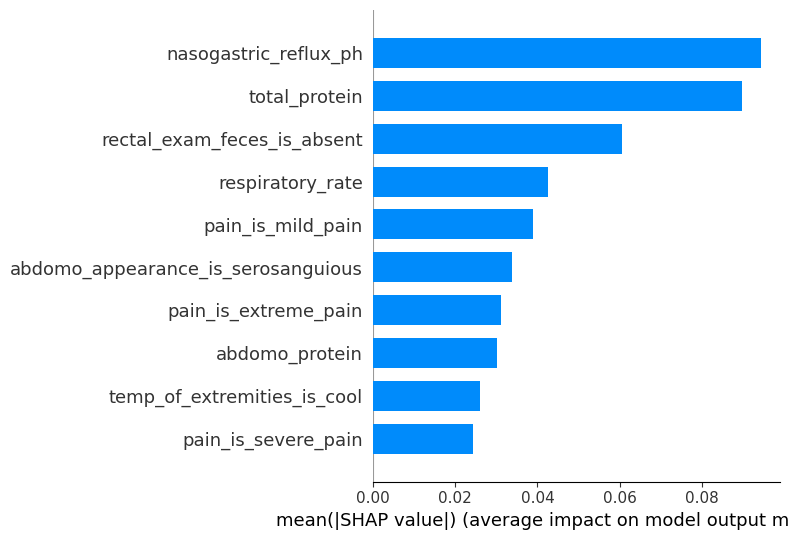

In [35]:
shap.summary_plot(shap_values[0], train_arr.astype(np.float32), feature_names=feature_names, plot_type="bar", max_display=10)

### For Outcome = euthanized

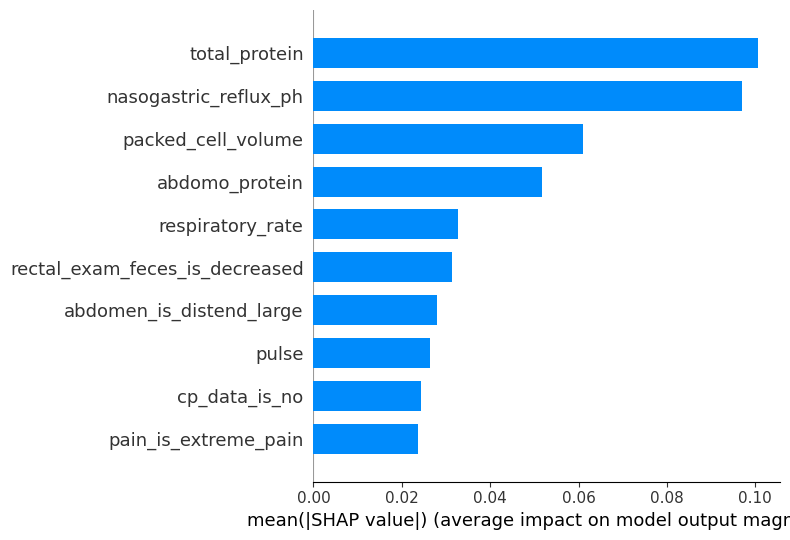

In [36]:
shap.summary_plot(shap_values[1], train_arr.astype(np.float32), feature_names=feature_names, plot_type="bar", max_display=10)

### For Outcome = lived

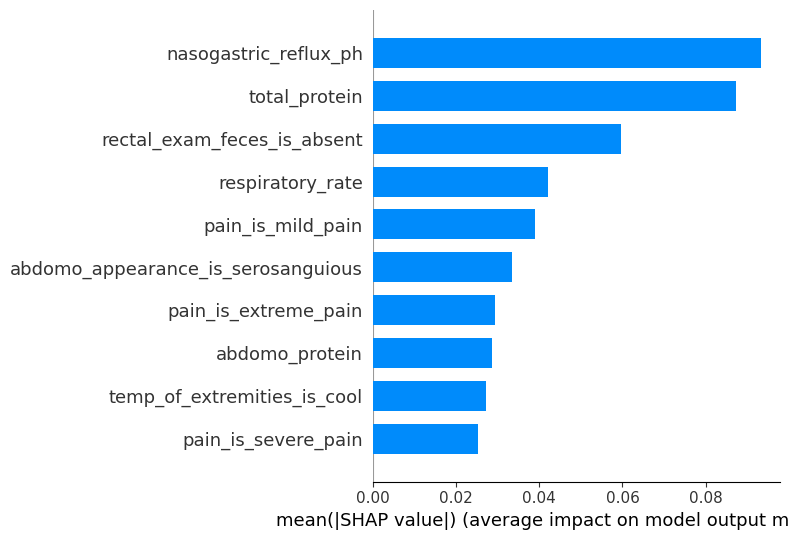

In [37]:
shap.summary_plot(shap_values[2], train_arr.astype(np.float32), feature_names=feature_names, plot_type="bar", max_display=10)